In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

sns.set(rc = {'figure.figsize' :  (15,6)})

events_data = pd.read_csv('/content/drive/MyDrive/BigData/event_data_train.csv')
submissions_data = pd.read_csv('/content/drive/MyDrive/BigData/submissions_data_train.csv')


In [ ]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')

In [ ]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [ ]:
events_data.date.min()  #первое действие на курсе

Timestamp('2015-06-15 04:00:48')

In [ ]:
events_data.date.max()  #последнее

Timestamp('2018-05-19 23:33:31')

In [ ]:
events_data['day'] = events_data.date.dt.date

<Axes: xlabel='day'>

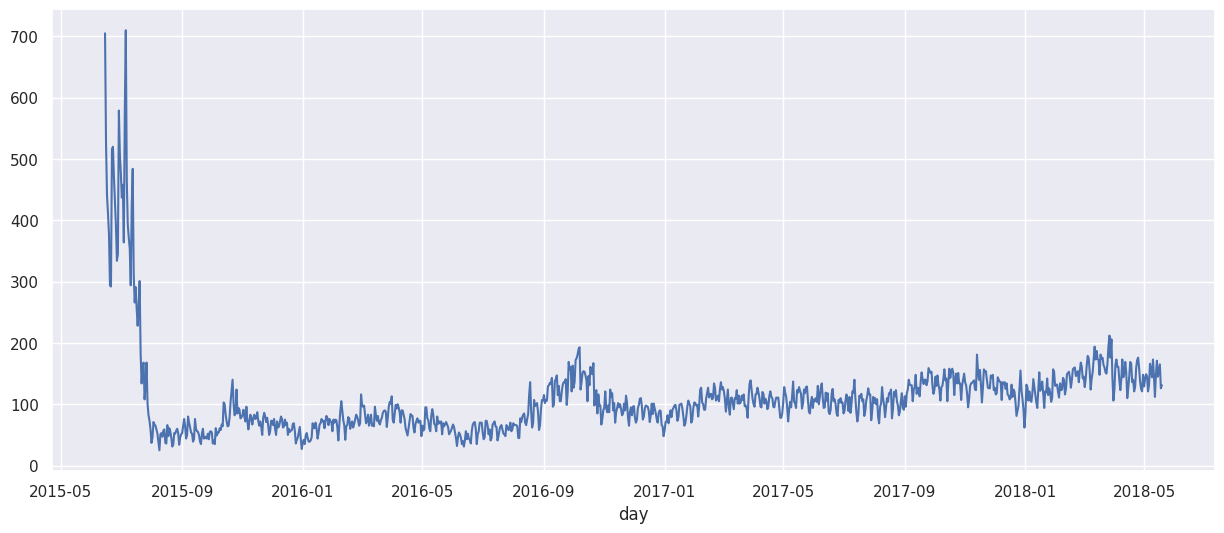

In [ ]:
events_data.groupby('day').user_id.nunique().plot()

<Axes: >

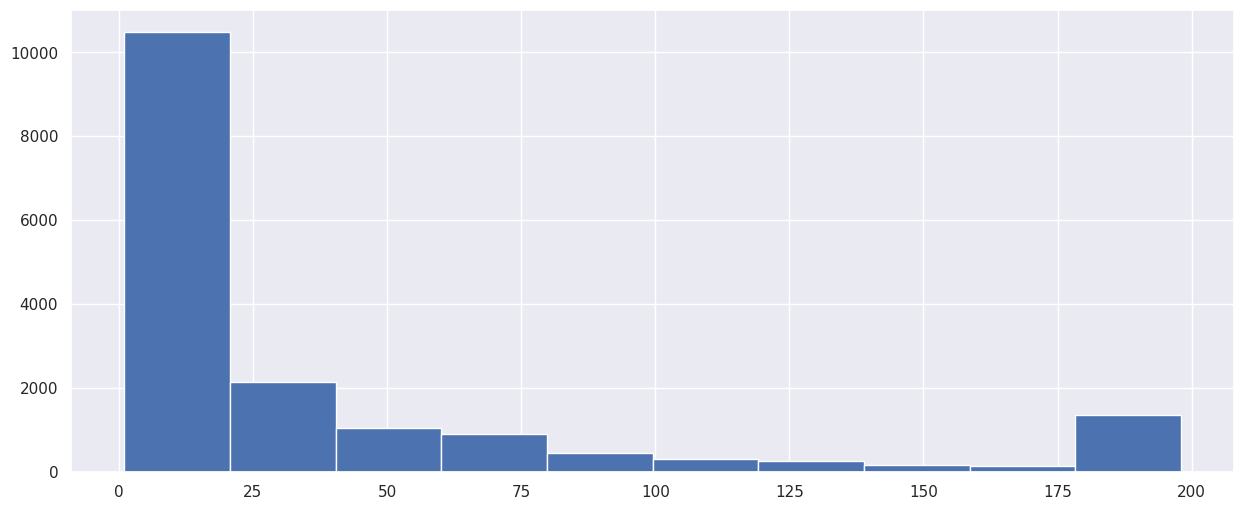

In [ ]:
events_data[events_data.action == 'passed'] \
.groupby('user_id', as_index = False) \
.agg({'step_id' : 'count'}) \
.rename(columns = {'step_id' : 'passed_steps'})\
.passed_steps.hist()


In [ ]:
actions = events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).\
                        reset_index()

actions[actions.user_id == 1046]    #доп задание на поиск определенного пользователя

action,user_id,discovered,passed,started_attempt,viewed
781,1046,128,124,721,8122


In [ ]:
actions

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


<Axes: >

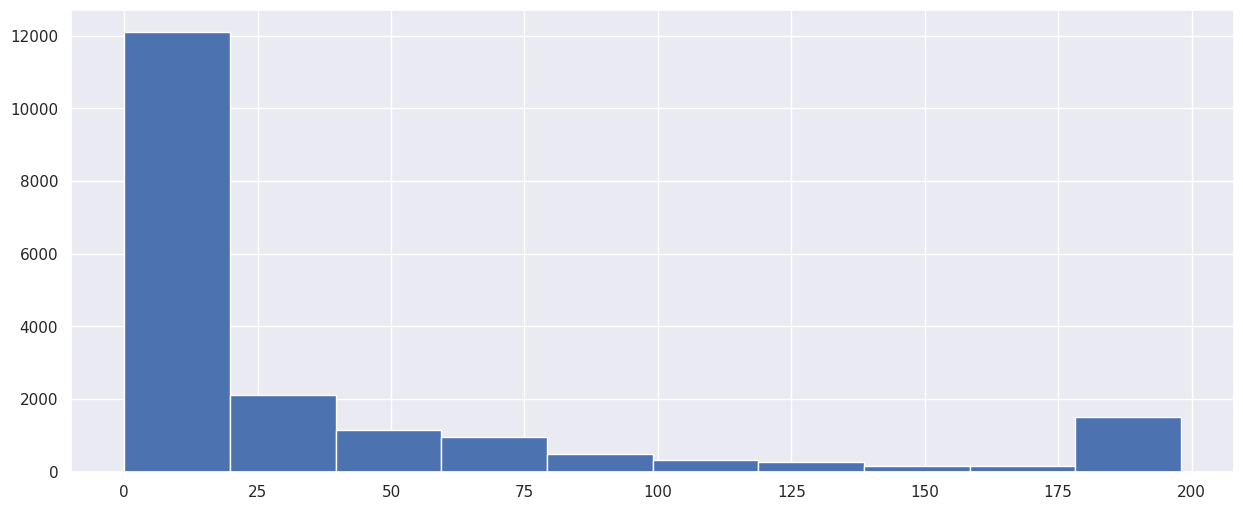

In [ ]:
actions.discovered.hist()

***1.11***

In [ ]:
users_scores = submissions_data.pivot_table(index = 'user_id',
                        columns = 'submission_status',
                        values = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).\
                        reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [ ]:
gap_data = events_data[['user_id','day','timestamp']].drop_duplicates(subset = ['user_id', 'day'])\
.groupby('user_id')['timestamp'].apply(list)\
.apply(np.diff).values

events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [ ]:
gap_data

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

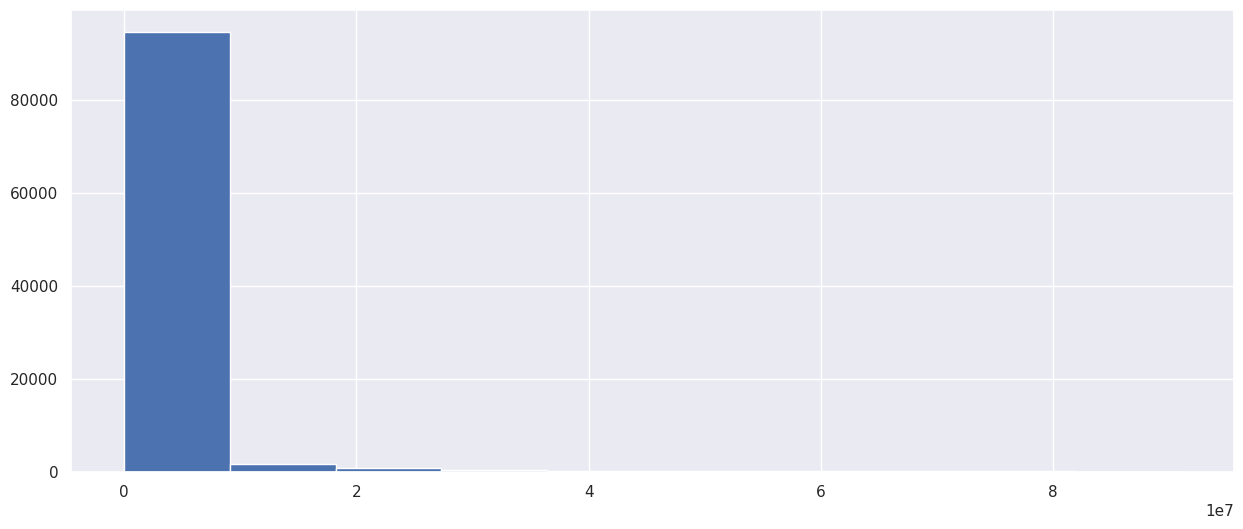

In [ ]:
gap_data = pd.Series(np.hstack(gap_data))
gap_data.hist()

gap_data = gap_data / (24*60*60)

gap_data.quantile(0.95)
month_time = 30 * 24*60*60
now = 1526772685



In [ ]:
user_data = events_data.groupby('user_id', as_index = False) \
.agg({'timestamp' : 'max'}).rename(columns = {'timestamp':'last_timestamp'})#для каждого пользователя найти время последней активности

user_data.head()


,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [ ]:
user_data['is_gone_user'] = now - user_data.last_timestamp > month_time     #текущее время минус время последней попытки > месяца значит пользователь дропнут

user_data.head()


,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [ ]:
user_data = user_data.merge(users_scores,on = 'user_id' , how= 'outer')

In [ ]:

user_data = user_data.merge(actions, how = 'outer')
user_data = user_data.fillna(0)

In [ ]:
user_days = events_data.groupby('user_id').day.nunique()

In [ ]:
user_days = user_days.to_frame().reset_index()
user_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [ ]:
user_data = user_data.merge(user_days, how= 'outer')

In [ ]:
user_data['passed_corse'] = user_data.passed > 170
user_data['passed_corse'].value_counts(normalize=True)

,proportion
passed_corse,
False,0.925912
True,0.074088


<Axes: >

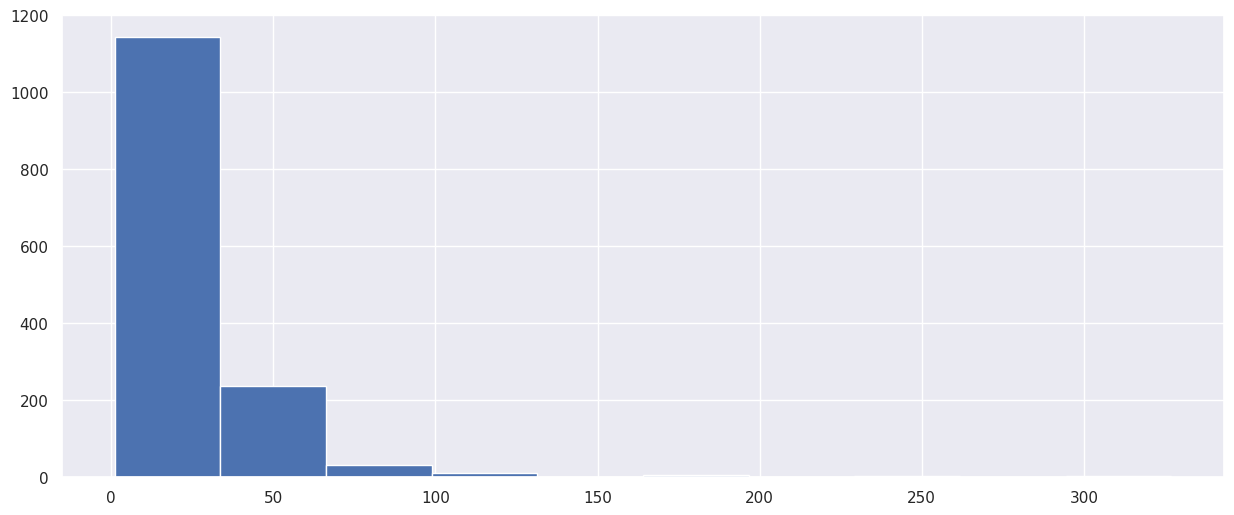

In [ ]:
user_data[user_data.passed_corse].day.hist() # количество дней у тех, кто прошёл курс

In [ ]:
user_min_time = events_data.groupby('user_id') \
.agg({'timestamp' : 'min'})\
.rename({'timestamp' : 'min_timestamp'}, axis = 1).reset_index()
user_min_time    #посчитали время первого степа для каждого узера

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [ ]:
events_data = events_data.merge(user_min_time, how= 'outer') # добавили время первого степа в таблицу с ивентами
events_data.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [ ]:
sec_in_3_days = 24*60*60*3      #отобрали ивенты за первые 3 дня

events_data_train = events_data[events_data.min_timestamp + sec_in_3_days > events_data.timestamp]

events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [ ]:
events_data_train.groupby('user_id').day.nunique().max()  #доказательство того что для кождого юзера 4 уникальных дня максимально

4

In [ ]:
submissions_data_train = submissions_data.merge(user_min_time, how= 'outer')

submissions_data_train = submissions_data_train[submissions_data_train.min_timestamp + sec_in_3_days > submissions_data_train.timestamp]

submissions_data_train.head() #отобрали сабмиты за первые 3 дня для каждого юзера

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977


Далее доп задание по самого сложного степа














In [ ]:
#для каждого степа посчитать количество правильных и неправильных

















count_of_subs_for_every_step = submissions_data.groupby(['step_id', 'submission_status']).\
count().\
reset_index().\
drop_duplicates(['user_id']).\
drop(['timestamp', 'user_id','day'], axis =1).\
sort_values('submission_status').\
rename(columns={'date': 'count'})

In [ ]:
count_of_subs_for_every_step[count_of_subs_for_every_step.submission_status == 'wrong'].sort_values('count').tail()

,step_id,submission_status,count
25,32075,wrong,10003
89,33481,wrong,10300
39,32202,wrong,13002
23,32031,wrong,13373
9,31978,wrong,16084


In [ ]:
submissions_data.sort_values(['user_id', 'timestamp'], ascending=False).drop_duplicates(['user_id'])\
        .query("submission_status == 'wrong'").groupby('step_id')\
        .count().sort_values('submission_status').tail()
#выполнение задания в один запрос

,timestamp,submission_status,user_id,date,day
step_id,,,,,
33481,78,78,78,78,78
32202,92,92,92,92,92
32031,97,97,97,97,97
32812,133,133,133,133,133
31978,154,154,154,154,154


In [ ]:
#выполнение задание от Карпова
submissions_data_by_step = submissions_data \
    .pivot_table(values='timestamp', index=['user_id', 'step_id'], aggfunc = 'max',
                 columns='submission_status', fill_value=0) \
    .reset_index()
submissions_data_by_step['is_solved'] = submissions_data_by_step.correct > 0

users_max_time = submissions_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})


not_solved_steps = submissions_data_by_step[submissions_data_by_step.is_solved == False]

not_solved_steps = not_solved_steps.merge(users_max_time, on='user_id')

not_solved_steps['is_last_action'] = not_solved_steps.wrong == not_solved_steps.last_timestamp

not_solved_steps_last_action = not_solved_steps[not_solved_steps.is_last_action == True]

not_solved_steps_last_action.groupby('step_id', as_index=False) \
    .agg({'user_id': 'count'}).sort_values('user_id', ascending=False).head()

,step_id,user_id
4,31978,151
28,32812,130
11,32031,95
19,32202,88
42,33481,78


In [ ]:


X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns = {'day':'days_of_3_days'})

step_tried =  submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
.rename(columns = {'step_id':'steps_tried'})
#добавили количество степов для каждого юзера за первые 3 дня


In [ ]:
X = X.merge(step_tried,on = 'user_id', how = 'outer')     #соединили дни и попытки
X.shape

(8913, 3)

In [ ]:
X = X.merge(submissions_data_train.pivot_table(index = 'user_id',
                        columns = 'submission_status',
                        values = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).\
                        reset_index(), how = 'outer', on = 'user_id') #сделали сводную таблицу по правильным и неправильным сабмитам и их количеству и прикрепили к Х

In [ ]:
X['correct_ratio'] = X.correct/ (X.correct+ X.wrong) #добавили процент правильных решений для каждого юзера

In [ ]:
X = X.merge(events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).\
                        reset_index()[['user_id', 'viewed']])
#добавили сводную таблицу по ивентам и их количеству
X = X.fillna(0)

In [ ]:
X = X.merge(user_data[['user_id','passed_corse', 'is_gone_user']], how = 'outer')
#добавили статус курс пройден и курс покинут

In [ ]:
X = X[X.is_gone_user | X.passed_corse]  #убрали тех кто не прошёл и не дропнулся, потому что про них ничего не известно


In [ ]:
X = X.drop(['is_gone_user'], axis = 1)
X = X.set_index(X.user_id).drop(['user_id'], axis = 1).fillna(0)
# дропнули лишние стоблцы, сделали юзера индексом, и заполнили пропуски нулями

In [ ]:
y = X.passed_corse
X = X.drop(['passed_corse'], axis = 1)
y.value_counts()

,count
passed_corse,
False,16560
True,1425


In [ ]:
from sklearn import metrics

def all_metrics(model, X_test, y_test):
    observations = y_test
    prediction = model.predict(X_test)

    true_positive = np.logical_and(prediction, observations)
    false_positive = np.logical_and(prediction, np.logical_not(observations))
    true_negative = np.logical_and(np.logical_not(prediction), np.logical_not(observations))
    false_negative = np.logical_and(np.logical_not(prediction), observations)

    tp, fp, tn, fn = (x.sum() for x in (true_positive, false_positive, true_negative, false_negative))
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (recall * precision) / (recall + precision)

    print('True Positive: ', tp)
    print('False Positive: ', fp)
    print('True Negative: ', tn)
    print('False Negative: ', fn)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 score: ', f1_score)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

parameters = {'n_neighbors': range(16,22), 'leaf_size':range(1,7)}

grid_search_cv_clf = GridSearchCV(KNeighborsClassifier(),parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_test,y_test,cv=4).mean())

y_pred = model.predict(X_test)

all_metrics(model, X_test, y_test)


{'leaf_size': 1, 'n_neighbors': 21} 0.9570051890289103
True Positive:  316
False Positive:  116
True Negative:  4870
False Negative:  94
Accuracy:  0.9610822831727205
Precision:  0.7314814814814815
Recall:  0.7707317073170732
F1 score:  0.7505938242280286


In [ ]:

from sklearn.tree import DecisionTreeClassifier

parameters = {"max_depth": range(1,20)}

grid_search_cv_clf = GridSearchCV(DecisionTreeClassifier(),parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_test,y_test,cv=4).mean())

y_pred = model.predict(X_test)

all_metrics(model, X_test, y_test)
tree = model

{'max_depth': 5} 0.9570051890289103
True Positive:  328
False Positive:  119
True Negative:  4867
False Negative:  82
Accuracy:  0.962750185322461
Precision:  0.7337807606263982
Recall:  0.8
F1 score:  0.7654609101516919


In [ ]:

from sklearn.linear_model import LogisticRegression

parameters = [{'penalty':['l1','l2']},
              {'C':[1, 10, 100, 1000]}]
grid_search_cv_clf = GridSearchCV(LogisticRegression(),parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_test,y_test,cv=4).mean())

y_pred = model.predict(X_test)

all_metrics(model, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
4 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/

{'C': 10} 0.9588584136397331
True Positive:  253
False Positive:  49
True Negative:  4937
False Negative:  157
Accuracy:  0.9618235730170497
Precision:  0.8377483443708609
Recall:  0.6170731707317073
F1 score:  0.7106741573033709
